# Analysis of Ukrainian Refugees Fleeing Neighbouring Countries

Since the start of the Russian invasion of Ukraine on 24 February 2022, Ukrainians have been fleeing the neighboring countries in masses. I decided to analyze this tragic event using the UNHCR's Ukraine Refugee Situation data available [here](http://data2.unhcr.org/en/situations/ukraine). 

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import matplotlib.ticker as tick

In [2]:
UNHCR_data_link = "https://data2.unhcr.org/population/get/sublocation?widget_id=283727&sv_id=54&population_group=5459,5460&forcesublocation=0&fromDate=1900-01-01"
last_update_link = "https://data2.unhcr.org/population/?widget_id=284494&sv_id=54&population_group=5459,5460&year=latest"

Thankfully the data is available at UNHCR's data portal as JSON. This is convenient in terms of access to the data with a single link but has downsides as you don't have access to historic data.

In [3]:
refugee_data = pd.read_json(UNHCR_data_link)

In [4]:
countries_refugees = {}

for i in range(len(refugee_data.data)):
    countries_refugees[refugee_data.data[i]["geomaster_name"]] = int(
        refugee_data.data[i]["individuals"]
    )

I used read_json() method of Pandas to turn it into a DataFrame. Then created a dictionary where the keys are the country names refugees fled and the values are the number of individuals. 

In [5]:
last_update_date_data = pd.read_json(last_update_link)

last_update_date = last_update_date_data.data[0]["date"]

last_date = datetime.date(
    int(last_update_date[:4]), int(last_update_date[5:7]), int(last_update_date[8:11])
)

I also wanted to add the last updated date to my data visualizations to give them more context. This is also available in a separate JSON link from UNHCR's website. I used string slicing and then turned that string into a date with the date function of datetime module. 

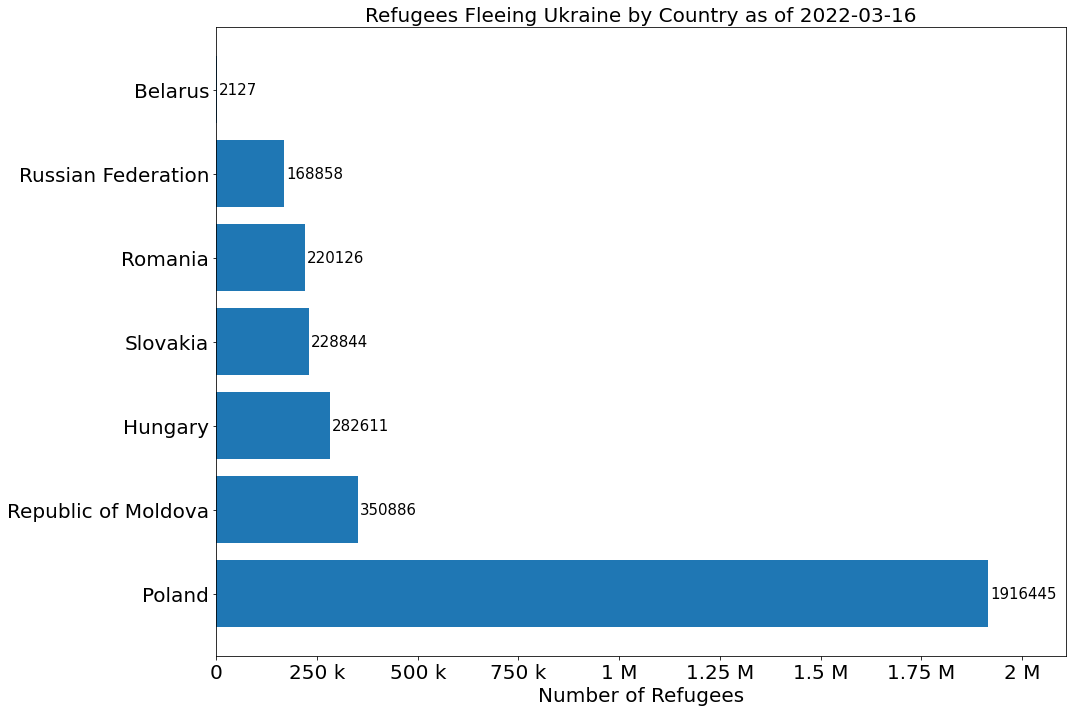

In [25]:
fig, ax = plt.subplots(figsize=(15, 10))

plt.title(f"Refugees Fleeing Ukraine by Country as of {last_date}", fontsize=20)

ax.bar_label(
    container=ax.barh(
        list(countries_refugees.keys()), list(countries_refugees.values())
    ),
    fmt="%.0f",
    label_type="edge",
    padding=2,
    fontsize=15,
)
ax.margins(x=0.1)
ax.tick_params(axis="both", labelsize=20)
ax.get_xaxis().get_major_formatter().set_scientific(False)

ax.xaxis.set_major_formatter(tick.EngFormatter())

plt.xlabel("Number of Refugees", fontsize=20)
plt.tight_layout()
plt.show()

The first plot is a horizontal bar chart that shows the total number of refugees in each country. By the first look, you can see that Poland was generous enough to host almost two million Ukrainian refugees on its own. However, I will consider the proportion of refugees against the host country population in the next section, which will tell us a different story. 

### Refugees Per 100,000 Host Population in the Ukrainian Refugee Situation

In [7]:
population = pd.read_excel("SWOP-Data-2021.xls", sheet_name="Demographic_2021")

In [8]:
refugee_receiving_countries = population[
    population["Demographic Indicators"].isin(list(countries_refugees.keys()))
].set_index("Demographic Indicators")

refugee_receiving_countries.rename(columns={"Unnamed: 3": "Population"}, inplace=True)

Next, I wanted to calculate the refugee per 100,000 host population in each country, meaning how many refugees are hosted in each country for every 100,000 host country citizens. For this purpose, I needed the population of the refugee receiving countries listed above and I found the United Nation's Population Fund's (UNFPA) World Population Data for 2021, which is available in this [link](https://www.unfpa.org/data/world-population-dashboard).

In [9]:
countries_population = {}
for i in range(len(refugee_receiving_countries.index)):
    countries_population[refugee_receiving_countries.index[i]] = int(
        (float(refugee_receiving_countries.iloc[i, 2])) * 1000000
    )

I already created a dictionary with the seven refugee receiving countries as a dictionary when I created the first plot. Now I created another dictionary for the population of these countries as key-value pairs. Since the UNFPA's data doesn't show the exact values for the population (e.g. Romania's population is 19.1), I multiplied each value by 1,000,000 before adding them to the dictionary. This way I also turned the string value into an integer.

In [10]:
refugee_ratios = {}
for country in countries_population:
    refugee_ratios[country] = int(
        (countries_refugees[country] / countries_population[country]) * 100000
    )

Now I have the number of refugees in each country and the population of that country in two different dictionaries. Here I created another dictionary to calculate the number of refugees per 100,000 host population. I divided the number of refugees with the number of the host community and multiplied that number by 100,000 in this new dictionary. 

In [11]:
ratio_tuples = sorted(refugee_ratios.items(), key=lambda item: item[1], reverse=True)
sorted_ratio = {k: v for k, v in ratio_tuples}

As I will later plot this dictionary, I wanted to sort them from the biggest to the lowest so that the plot would look good. For this purpose, I created a lambda function to create tuples and then unpacked the tuples in a new dictionary.

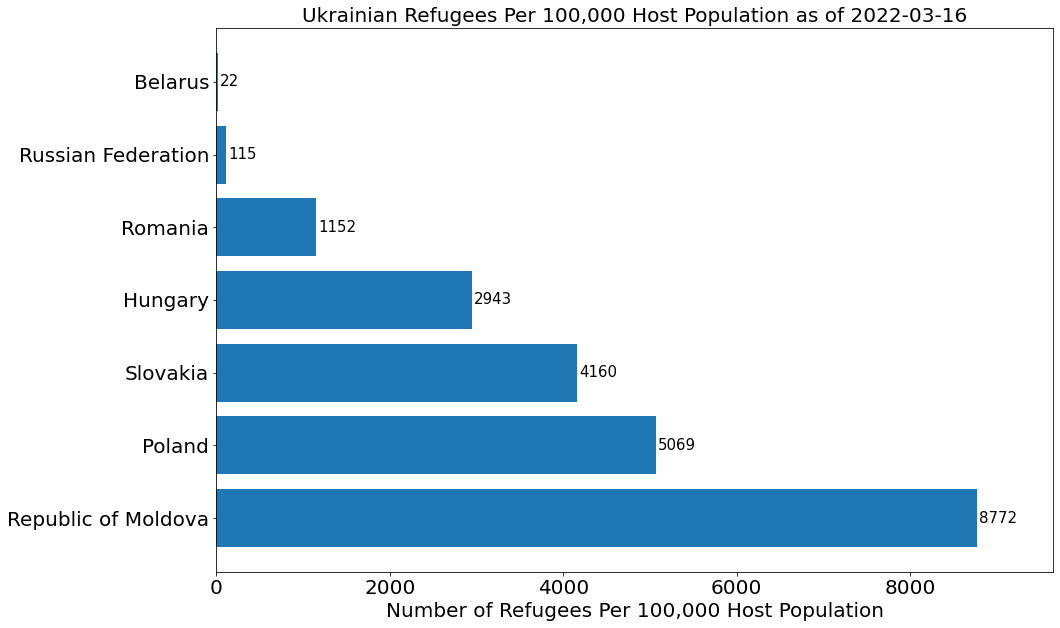

In [12]:
fig, ax = plt.subplots(figsize=(15, 10))

plt.title(
    f"Ukrainian Refugees Per 100,000 Host Population as of {last_date}", fontsize=20
)

ax.bar_label(
    container=ax.barh(list(sorted_ratio.keys()), list(sorted_ratio.values())),
    labels=sorted_ratio.values(),
    label_type="edge",
    padding=2,
    fontsize=15,
)
ax.tick_params(axis="both", labelsize=20)
ax.margins(x=0.1)
plt.xlabel("Number of Refugees Per 100,000 Host Population", fontsize=20)
plt.show()

This plot above tells us a different story than the first. Even though Moldova does not hold the biggest number of refugees, its tiny population means it hosts the biggest refugee population per 100,000 host country citizens. As Moldova is among the least developed of these countries and is not an EU member state at the moment, this may situation may overstretch its capabilities shortly. 

To contextualize these numbers, think about the biggest refugee-hosting country in the world, Turkey. Turkey hosts around 4 million refugees at the moment. The exact number is not known as only the number of Syrians (3,7 million) is public knowledge and Turkey is estimated to host around 500,000 other nationalities as well. With 4 million refugees against the 84 million Turkish citizens, Turkey hosts around 4700 refugees per its 100,000 citizens. Moldova has almost double that number and Poland passed that number in terms of refugees per 100,000 host population. 

### Cumulative Number of Refugees by Date

Finally, let's examine the increase of the cumulative number of refugees by date. This is also available in UNHCR's data portal, the link of which can be found at the beginning of this document. 

In [13]:
link_by_date = "https://data2.unhcr.org/population/get/timeseries?widget_id=285656&sv_id=54&population_group=5460&frequency=day&fromDate=1900-01-01"
refugees_by_date = pd.read_json(link_by_date)

I use the read_json() method again to parse the JSON for the cumulative number of refugees and store the DataFrame in a variable.

In [14]:
dates = []
refugees = []

for i in range(len(refugees_by_date.data[0])):
    dates.append(refugees_by_date.data[0][i]['data_date'][5:])
    refugees.append(int(refugees_by_date.data[0][i]['individuals']))

As this will be a simple line plot, I created two separate lists. One of them is for the dates in month-day format and the other is for the number of cumulative refugees corresponding to that date.

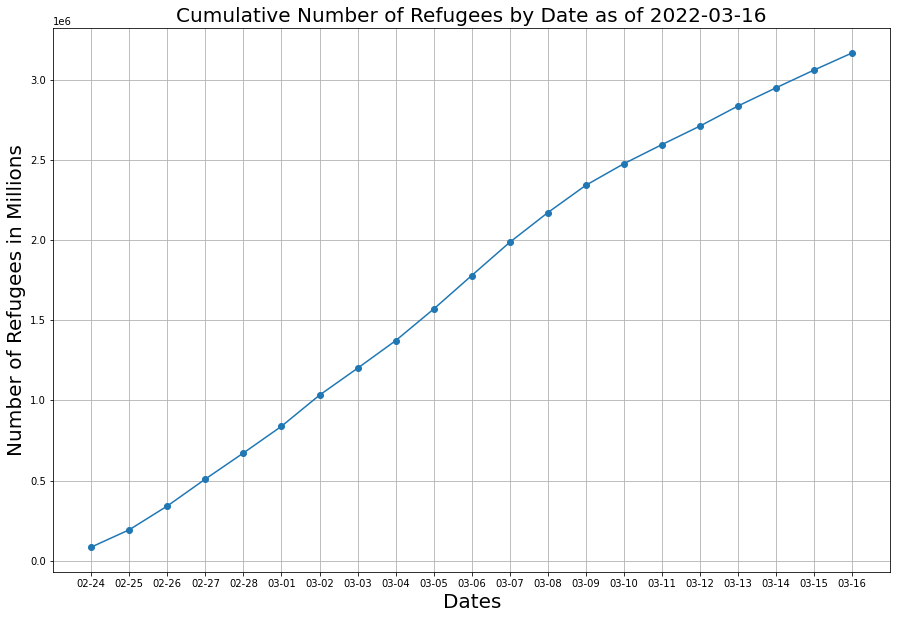

In [15]:
fig, ax = plt.subplots(figsize=(15, 10))

plt.title(f"Cumulative Number of Refugees by Date as of {last_date}", fontsize=20)

ax.plot(dates, refugees, marker="o")

plt.xlabel("Dates", fontsize=20)
plt.ylabel("Number of Refugees in Millions", fontsize=20)
ax.tick_params(axis="both", labelsize=10)

plt.grid()
plt.show()

The alarming increase in the cumulative numbers can be examined here. It took 7 days to reach 1 million refugees point, another 5 days later the number reached 2 million and lastly the 3 million mark came 8 days later.